In [65]:
import types
import numpy as np
import collections
import os
import pandas as pd
from PIL import Image
from random import shuffle

import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline

class ExternalInputIterator(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        path = "../../storage/inpainting-dataset/train/"
        self.files = [path+i for i in os.listdir(path)]
        shuffle(self.files)
        

    def __iter__(self):
        self.i = 0
        self.n = len(self.files)
        return self

    def __next__(self):
        batch = []
        for _ in range(self.batch_size):
            # *label reads multiple labels 
            filename = self.files[self.i]
            f = open(filename, 'rb')
            batch.append(np.frombuffer(f.read(), dtype = np.uint8))
            self.i = (self.i + 1) % self.n
        return batch

    next = __next__

In [61]:
f = open("../../storage/inpainting-dataset/256/43fc576ea93f73eb_resized.jpg", 'rb')

In [68]:
a = np.frombuffer(f.read(), dtype = np.uint8)

In [69]:
b=ops.ImageDecoder(device = "mixed", output_type = types.RGB)

In [59]:
eii = ExternalInputIterator(batch_size=256)
iterator = iter(eii)

In [66]:
class ExternalSourcePipeline(Pipeline):
    def __init__(self, data_iterator, batch_size, num_threads, device_id):
        super(ExternalSourcePipeline, self).__init__(batch_size,
                                      num_threads,
                                      device_id,
                                      seed=12)
        self.data_iterator = data_iterator
        self.input = ops.ExternalSource()
        self.decode = ops.ImageDecoder(device = "mixed", output_type = types.RGB)
        # resizing is *must* because loaded images maybe of different sizes
        # and to create GPU tensors we need image arrays to be of same size
        self.res = ops.Resize(device="gpu", resize_x=224, resize_y=224, interp_type=types.INTERP_TRIANGULAR)

    def define_graph(self):
        self.jpegs = self.input()
        images = self.decode(self.jpegs)
#         output = self.res(images)
        return (images)

    def iter_setup(self):
        # the external data iterator is consumed here and fed as input to Pipeline
        images = self.data_iterator.next()
        self.feed_input(self.jpegs, images)


In [67]:
from nvidia.dali.plugin.pytorch import DALIGenericIterator

pipe = ExternalSourcePipeline(data_iterator=iterator, batch_size=256, num_threads=2, device_id=0)
pipe.build()

# first parameter is list of pipelines to run
# second pipeline is output_map that maps consecutive outputs to 
#   corresponding names
# last parameter is the number of iterations - number of examples you
# want to iterate on


In [62]:
len(eii.files)//256

6808

In [72]:
dali_iter = DALIGenericIterator([pipe], ['images'], 6808)

/usr/local/lib/python3.6/dist-packages/nvidia/dali/plugin/base_iterator.py:124: Warning: Please set `reader_name` and don't set last_batch_padded and size manually  whenever possible. This may lead, in some situations, to miss some  samples or return duplicated ones. Check the Sharding section of the documentation for more details.
  _iterator_deprecation_warning()


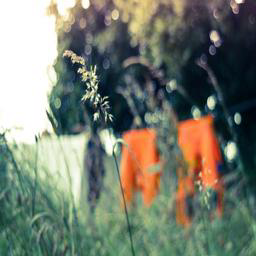

In [22]:
Image.fromarray(images[3].cpu().numpy())

In [75]:
import time
for i, it in enumerate(dali_iter):
    start = time.time()
    batch_data = it
    end = time.time()
    test_time = end-start
    # print('[DALI] iteration time: %fs [train],  %fs [test]' % (train_time, test_time))
    print('[DALI] iteration time: %fs [test]' % (test_time))
    print(i)
#     break

[DALI] iteration time: 0.000004s [test]
0
[DALI] iteration time: 0.000002s [test]
1
[DALI] iteration time: 0.000002s [test]
2
[DALI] iteration time: 0.000003s [test]
3
[DALI] iteration time: 0.000002s [test]
4
[DALI] iteration time: 0.000002s [test]
5
[DALI] iteration time: 0.000003s [test]
6
[DALI] iteration time: 0.000002s [test]
7
[DALI] iteration time: 0.000002s [test]
8
[DALI] iteration time: 0.000003s [test]
9
[DALI] iteration time: 0.000002s [test]
10
[DALI] iteration time: 0.000003s [test]
11
[DALI] iteration time: 0.000003s [test]
12
[DALI] iteration time: 0.000002s [test]
13
[DALI] iteration time: 0.000002s [test]
14
[DALI] iteration time: 0.000002s [test]
15
[DALI] iteration time: 0.000002s [test]
16
[DALI] iteration time: 0.000002s [test]
17
[DALI] iteration time: 0.000003s [test]
18
[DALI] iteration time: 0.000002s [test]
19
[DALI] iteration time: 0.000002s [test]
20


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



[DALI] iteration time: 0.000003s [test]
21
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-75-f34c7b86efb7>", line 2, in <module>
    for i, it in enumerate(dali_iter):
  File "/usr/local/lib/python3.6/dist-packages/nvidia/dali/plugin/pytorch.py", line 231, in __next__
    p.schedule_run()
  File "/usr/local/lib/python3.6/dist-packages/nvidia/dali/pipeline.py", line 528, in schedule_run
    self._run_once()
  File "/usr/local/lib/python3.6/dist-packages/nvidia/dali/pipeline.py", line 633, in _run_once
    self._iter_setup()
  File "/usr/local/lib/python3.6/dist-packages/nvidia/dali/pipeline.py", line 844, in _iter_setup
    self.iter_setup()
  File "<ipython-input-66-4f037929ef6a>", line 22, in iter_setup
    images = self.data_iterator.next()
  File "<ipython-input-4-a610632e0285>", line 32, in __next__
    batch.appen

KeyboardInterrupt: 

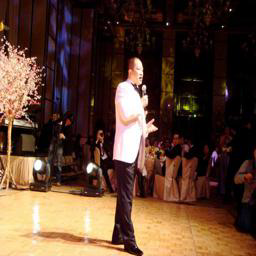

In [97]:
Image.fromarray(images[2].cpu().numpy())

In [77]:
import torchvision
import torch
def load_dataset():
    data_path = '../../storage/inpainting-dataset/256/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=256,
        num_workers=0,
        shuffle=True
    )
    return train_loader



In [78]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class AsetheticsDataset(Dataset):
      '''asethitics dataset'''
      def __init__(self,transform=None):
        #     self.data.rename(columns=columns,inplace=True)
    #     self.data.drop(self.data.columns[[1,2,3,4,5,6,8,9]] , axis=1,inplace=True)
        self.root_dir = "../../storage/inpainting-dataset/train/"
        self.data = b
        self.transform = torchvision.transforms.ToTensor()
    
      def __len__(self):
        return len(self.data)
  
      def __getitem__(self,idx):
   
        if torch.is_tensor(idx):
          idx = idx.tolist()
       
        image_name = self.data[idx]
        image = Image.open(image_name)
#     return_sample={}
        return_sample = {
              'image':image,
        }
        if self.transform:
            return_sample = self.transform(return_sample["image"])
    
     
        return return_sample

In [52]:
a= AsetheticsDataset()

In [79]:
train_loader = torch.utils.data.DataLoader(
       a,
        batch_size=256,
        num_workers=0,
        shuffle=True
    )

In [58]:
for batch_idx, (data) in enumerate(train_loader):
    print(batch_idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


KeyboardInterrupt: 

In [2]:
data_path = '../../storage/inpainting-dataset/256/'
train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )

KeyboardInterrupt: 